# Newton's method

As a demo of Newton's method, we will use the "hello world" of continuous optimization, the Rosenbrock function family.

In [46]:
rosenbrock(b) = rosenbrock(b,2)
rosenbrock(b,n) = (x) -> sum( (1-x[2k-1])^2 + b*(x[2k]-x[2k-1]^2)^2 for k = 1:n÷2 )

rosenbrock (generic function with 2 methods)

In [47]:
using Plots

In 2D, a Rosenbrock function has a fairly narrow valley around the curve $y=x^2$. The global (and only local) minimizer is $(1,1)$. 

f([1, 1]) = 0


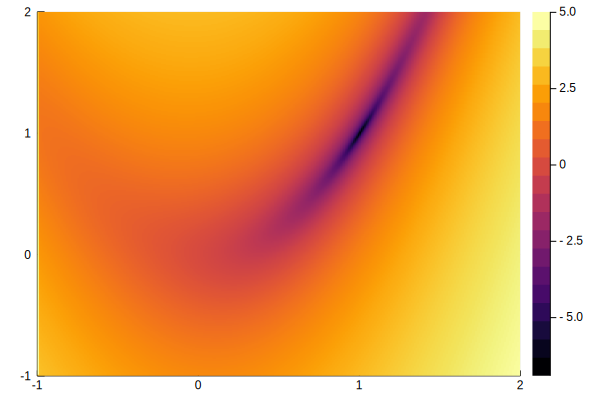

In [48]:
f = rosenbrock(6)
@show f([1,1])

x = -1:0.01:2
logf = (x,y) -> log(.001+f([x,y]))
contourf(x,x,logf,levels=20)

The `ForwardDiff` package will take gradients and Hessians for us automagically.

In [76]:
using ForwardDiff
gradf = x -> ForwardDiff.gradient(f,x);

gradf([1, 1]) = [0, 0]


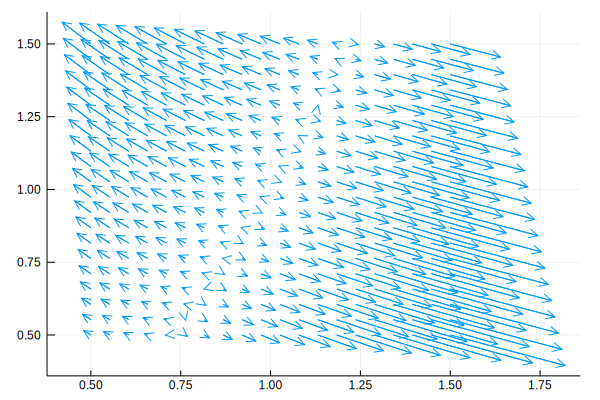

In [78]:
@show gradf([1,1])
g = (x,y) -> gradf([x,y])/200
x = range(0.5,stop=1.5,length=20)
grid = [ (x,y) for x in x, y in x ]
quiver(vec(grid),gradient=g)

Here is a quadratic model function for $f$ based on a point near the origin.

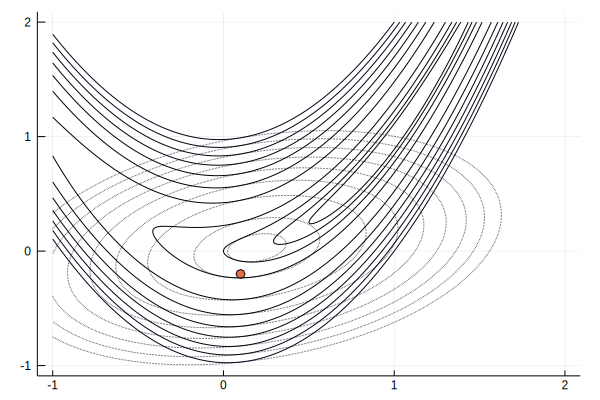

In [162]:
f = rosenbrock(20)
gradf = x -> ForwardDiff.gradient(f,x);
hessf = x -> ForwardDiff.hessian(f,x);

x = -1:0.01:2
lev = [0;.25;.5;1;range(2,stop=20,length=8)]
contour(x,x,(x,y)->f([x,y]),levels=lev,leg=false)

xc = [0.1,-0.2]
plot!([xc[1]],[xc[2]],m=:o)

m(x) = f(xc) + gradf(xc)'*(x-xc) + (x-xc)'*hessf(xc)*(x-xc)/2;
contour!(x,x,(x,y)->m([x,y]),l=:dot,levels=lev,leg=false)

The minimizer of this model defines the next Newton iterate.

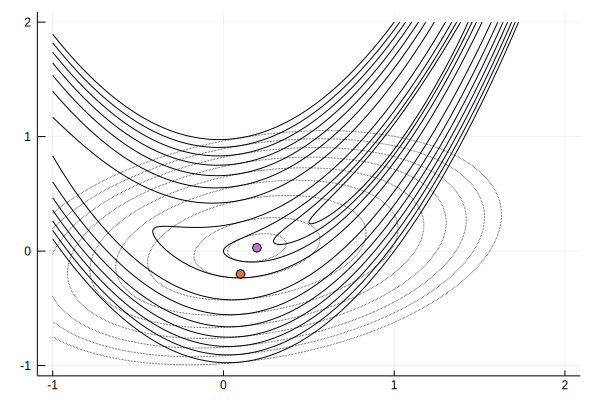

In [163]:
s = -hessf(xc)\gradf(xc)
xc += s
plot!([xc[1]],[xc[2]],m=:o)

Lather, rinse, repeat.

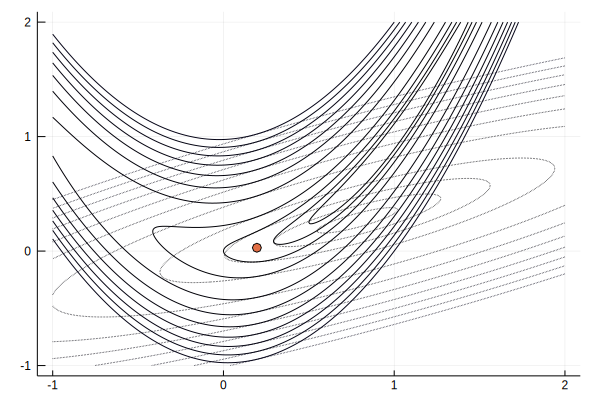

In [164]:
contour(x,x,(x,y)->f([x,y]),levels=lev,leg=false)
plot!([xc[1]],[xc[2]],m=:o)
contour!(x,x,(x,y)->m([x,y]),l=:dot,levels=lev,leg=false)

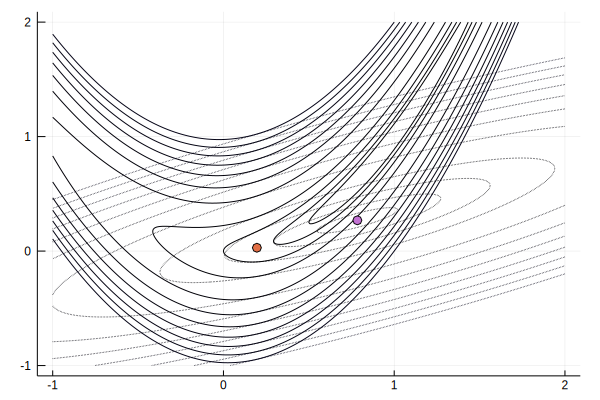

In [165]:
s = -hessf(xc)\gradf(xc)
xc += s
plot!([xc[1]],[xc[2]],m=:o)

s = -(hessf(xc)) \ gradf(xc) = [0.0957447, 0.229149]
s = -(hessf(xc)) \ gradf(xc) = [0.588473, 0.239548]
s = -(hessf(xc)) \ gradf(xc) = [0.0145288, 0.369088]
s = -(hessf(xc)) \ gradf(xc) = [0.199568, 0.31902]
s = -(hessf(xc)) \ gradf(xc) = [0.00064982, 0.041125]
s = -(hessf(xc)) \ gradf(xc) = [0.00103521, 0.0020687]
s = -(hessf(xc)) \ gradf(xc) = [1.74846e-8, 1.10663e-6]
s = -(hessf(xc)) \ gradf(xc) = [7.49512e-13, 1.49925e-12]


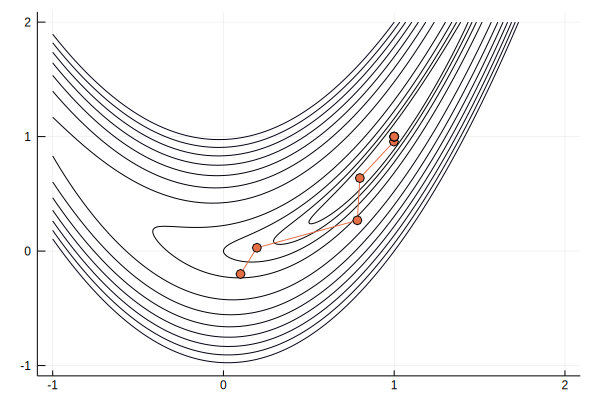

In [166]:
contour(x,x,(x,y)->f([x,y]),levels=lev,leg=false)
xnewt = [0.1,-0.2]

for k = 1:8
    xc = xnewt[:,end]
    @show s = -hessf(xc)\gradf(xc)
    xnewt = [xnewt xc+s]
end

plot!(xnewt[1,:],xnewt[2,:],m=:o)

## Parameter ID problem

Let's revisit the ODE parameter identification problem from earlier. We have two unknown parameters in a linear oscillator. 

In [3]:
using DifferentialEquations,Plots

# Time derivative in the ODE
function dydt(ydot,y,p,t) 
    ydot[1] = y[2]
    ydot[2] = -p[1]*y[2]-p[2]*y[1]
end

# Solution of the model
function SHO(p,t)
    ode = ODEProblem(dydt,[2.,0],(0.,40.),p)
    sol = solve(ode,abstol=1e-13,reltol=1e-12)
    return sol.(t,idxs=1)
end

┌ Info: Recompiling stale cache file /Users/driscoll/.julia/compiled/v1.0/DifferentialEquations/UQdwS.ji for DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
└ @ Base loading.jl:1190


SHO (generic function with 1 method)

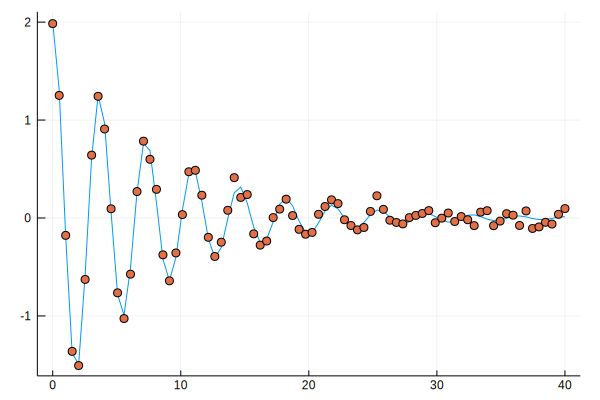

In [36]:
t = range(0,stop=40,length=80)
exact = SHO([0.25,3.],t) 
data = exact + 0.05*randn(80)
plot(t,exact,leg=false)
scatter!(t,data,leg=false)

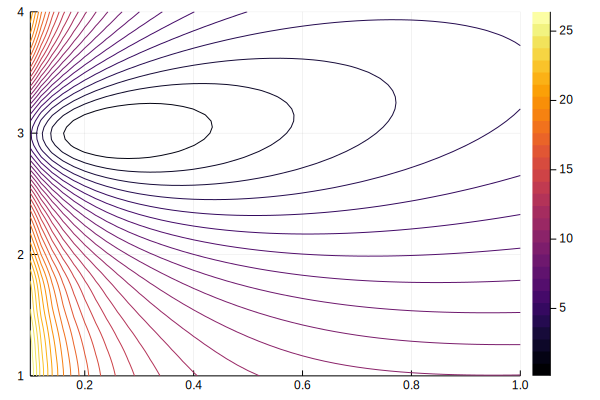

In [62]:
misfit(p) = SHO(p,t) - data
obj(x) = sum(misfit(x).^2)/2
contour(0.1:.02:1,1:.05:4,(c,k)->obj([c,k]),levels=30)

The `Calculus` package makes it easy to compute finite differences.

In [63]:
using Calculus
jac(p) = Calculus.finite_difference_jacobian(misfit,p)
jac([.25,3])

80×2 Array{Float64,2}:
  0.0          0.0      
  0.112775    -0.215811 
  0.663894    -0.535936 
  1.3356      -0.415406 
  1.32284      0.263131 
  0.216591     0.998165 
 -1.40875      1.09303  
 -2.31796      0.306819 
 -1.62424     -0.858218 
  0.376636    -1.50778  
  2.29926     -1.07179  
  2.68015      0.202775 
  1.12898      1.39783  
  ⋮                     
  0.459145    -0.0754474
  0.346347     0.143724 
  0.00664562   0.243949 
 -0.305895     0.167555 
 -0.379547    -0.0165372
 -0.18625     -0.171971 
  0.116371    -0.194876 
  0.310617    -0.0820885
  0.273692     0.0762069
  0.0529017    0.167199 
 -0.182971     0.134974 
 -0.270957     0.0134215

So it is easy to define the gradient of the misfit norm squared. (This is not efficient with calls to the ODE solver, though.) 

In [64]:
grad(p) = jac(p)'*misfit(p)
grad([.25,3])

2-element Array{Float64,1}:
  0.18072499680981624
 -0.20165484544932685

As long as we're not getting fussy about efficiency, we can easily do the FD Hessian as well.

In [65]:
hess(p) = Calculus.finite_difference_hessian(obj,p)
hess([.25,3])

2×2 Array{Float64,2}:
 125.215    -7.15367
  -7.15367  43.7848 

Pure Newton does work here, but only if we use a fairly good initial guess. 

In [66]:
xnewt = [.3,2.9]

for k = 1:8
    @show xc = xnewt[:,end]
    s = -hess(xc)\grad(xc)
    xnewt = [xnewt xc+s]
end

xc = xnewt[:, end] = [0.3, 2.9]
xc = xnewt[:, end] = [0.191795, 3.06265]
xc = xnewt[:, end] = [0.224811, 3.01263]
xc = xnewt[:, end] = [0.244225, 3.00484]
xc = xnewt[:, end] = [0.248655, 3.00438]
xc = xnewt[:, end] = [0.248841, 3.00439]
xc = xnewt[:, end] = [0.248841, 3.00439]
xc = xnewt[:, end] = [0.248841, 3.00439]
